In [ ]:
import os
import cv2
# from google.colab import drive
# drive.mount('/content/drive')
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import albumentations as A
import seaborn as sns
from skimage import exposure
from skimage import transform as tf
from tqdm import tqdm
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score

from keras import Sequential, Input, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Dropout

/Users/aashigoyal/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
def process_img(filepath):
    filenames = list(Path(filepath).glob(r'**/*{}'.format('jpg')))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filenames))

    filepaths = pd.Series(filenames, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df.sample(frac=1)

In [ ]:
# Access California Data
cali_train_path = '/Users/aashigoyal/Desktop/vscode/aashimain/aisd_whole/Data/California/train'
cali_test_path = '/Users/aashigoyal/Desktop/vscode/aashimain/aisd_whole/Data/California/test'
cali_val_path = '/Users/aashigoyal/Desktop/vscode/aashimain/aisd_whole/Data/California/valid'

# Process Data
cali_train_df = process_img(cali_train_path)
cali_val_df = process_img(cali_test_path)
cali_test_df = process_img(cali_val_path)

In [ ]:
print(cali_train_df.shape)
print(cali_test_df.shape)
print(cali_val_df.shape)

(1993, 2)
(429, 2)
(429, 2)


In [ ]:
# Access Canada Data
can_train_path = '/Users/aashigoyal/Desktop/vscode/aashimain/aisd_whole/Data/Canada/train'
can_test_path = '/Users/aashigoyal/Desktop/vscode/aashimain/aisd_whole/Data/Canada/test'
can_val_path = '/Users/aashigoyal/Desktop/vscode/aashimain/aisd_whole/Data/Canada/valid'

# Process Data
can_train_df = process_img(can_train_path)
can_val_df = process_img(can_val_path)
can_test_df = process_img(can_test_path)

In [ ]:
print(can_train_df.shape)
print(can_test_df.shape)
print(can_val_df.shape)

(30250, 2)
(6300, 2)
(6310, 2)


In [ ]:
can_train_df1=can_train_df.sample(frac=0.07,random_state=1)
can_test_df1=can_test_df.sample(frac=0.07,random_state=1)
can_val_df1=can_val_df.sample(frac=0.07,random_state=1)

In [ ]:
print(can_train_df1.shape)
print(can_test_df1.shape)
print(can_val_df1.shape)

(2118, 2)
(441, 2)
(442, 2)


In [ ]:
def show_image_sample(df, num_images=16):
    selected_data = df.head(num_images)
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(selected_data.iloc[i].Filepath))
        ax.set_title(selected_data.iloc[i].Label)
    plt.tight_layout()
    plt.show()

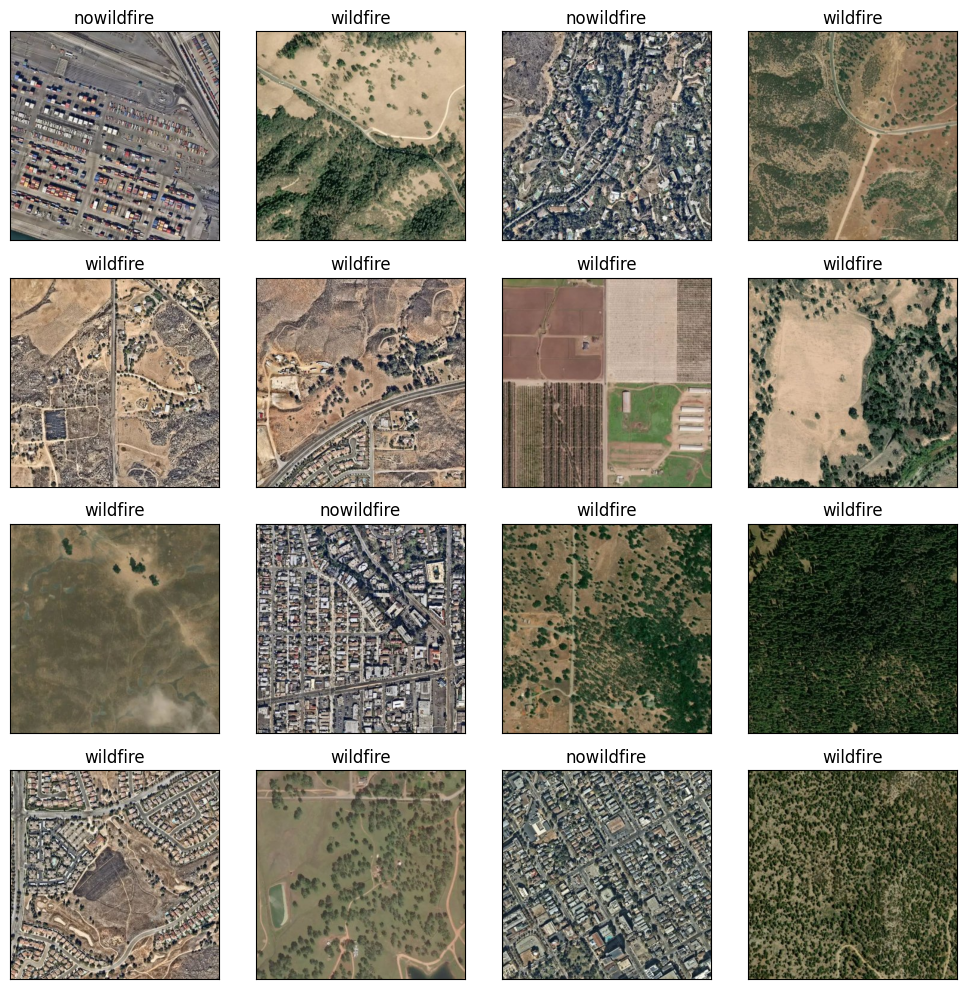

In [ ]:
show_image_sample(cali_train_df)

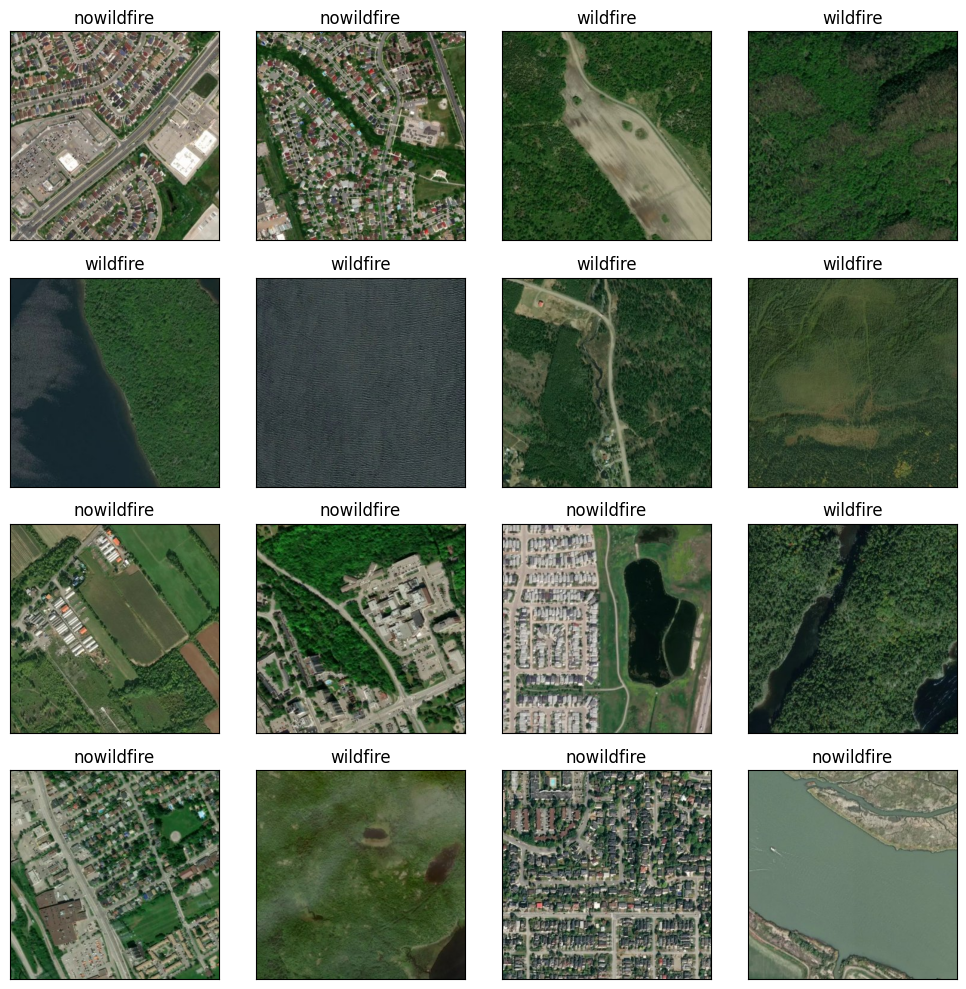

In [ ]:
show_image_sample(can_train_df)

In [ ]:
pip install rasterio


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 18.8 MB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 10.3 MB/s eta 0:00:01
     |████████████████████████████████| 61 kB 34.9 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import rasterio

def get_number_of_bands(image_path):
    with rasterio.open(image_path) as img:
        return img.count  # Number of bands

image_path = '/Users/aashigoyal/Desktop/vscode/aashimain/aisd_whole/Data/California/test/nowildfire/-117.096802,32.722216.jpg'
num_bands = get_number_of_bands(image_path)
print("Number of bands:", num_bands)


Number of bands: 3


/Users/aashigoyal/Library/Python/3.9/lib/python/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


DATA PREPROCESSING

In [ ]:
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import numpy as np

def preprocess_image(image_path, target_size=(299, 299)):
    """
    Preprocesses the image by loading, resizing, and normalizing it.
    Assumes that images are in RGB if they are color images.
    """
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = image / 255.0  # Normalize to [0, 1]
    return image

def process_images_batch(dataframe, batch_size=500):
    processed_images = []
    processed_labels = []

    for i in range(0, len(dataframe), batch_size):
        batch_df = dataframe[i:i + batch_size]
        # Process each image in the batch with tqdm progress bar for each image
        for filepath in tqdm(batch_df['Filepath'], desc=f'Processing batch {i//batch_size}', unit='image'):
            processed_img = preprocess_image(filepath)
            processed_images.append(processed_img)

            label = 0 if batch_df[batch_df['Filepath'] == filepath]['Label'].iloc[0] == 'nowildfire' else 1
            processed_labels.append(label)

    # Convert processed images to numpy array for DataFrame
    processed_images = np.array(processed_images)

    # Create new DataFrame
    new_df = pd.DataFrame({
        'Processed_Image': list(processed_images),
        'Label': processed_labels
    })

    return new_df


In [ ]:
processed_cali_train_df = process_images_batch(cali_train_df)

Processing batch 3: 100%|██████████| 493/493 [00:01<00:00, 347.00image/s]


In [ ]:
processed_cali_test_df = process_images_batch(cali_test_df)
processed_cali_val_df = process_images_batch(cali_val_df)

Processing batch 0: 100%|██████████| 429/429 [00:00<00:00, 468.44image/s]


In [ ]:
processed_can_train_df = process_images_batch(can_train_df1)

Processing batch 4: 100%|██████████| 118/118 [00:00<00:00, 477.32image/s]


In [ ]:
processed_can_val_df = process_images_batch(can_val_df1)
processed_can_test_df = process_images_batch(can_test_df1)

Processing batch 0: 100%|██████████| 441/441 [00:01<00:00, 429.23image/s]


In [ ]:
# Concatenate dataframes for both classes
train_df = pd.concat([processed_cali_train_df, processed_can_train_df], ignore_index=True)
test_df = pd.concat([processed_cali_test_df, processed_can_test_df], ignore_index=True)
valid_df = pd.concat([processed_cali_val_df, processed_can_val_df], ignore_index=True)

In [ ]:
#Preparing Tensorflow dataset
from tensorflow.data import Dataset

def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('Label')
    ds = Dataset.from_tensor_slices((list(dataframe['Processed_Image']), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds


batch_size = 500
train_ds = df_to_dataset(train_df, batch_size=batch_size)
val_ds = df_to_dataset(valid_df, batch_size=batch_size)
test_ds = df_to_dataset(test_df, batch_size=batch_size)


In [ ]:
#Define the model
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load InceptionResNetV2 pre-trained on ImageNet data
base_model = InceptionResNetV2(weights='imagenet', include_top=False)
base_model.trainable = False  # Freeze the base model

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
#Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
#Train the model
epochs = 30  # Adjust as needed
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/30


2023-12-04 02:23:12.348577: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 2594 of 4111
2023-12-04 02:23:20.067887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


9/9 [==============================] - 415s 44s/step - loss: 0.5337 - accuracy: 0.7879 - val_loss: 0.3698 - val_accuracy: 0.8760
Epoch 2/30


2023-12-04 02:30:03.592466: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 2661 of 4111
2023-12-04 02:30:11.107583: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


9/9 [==============================] - 396s 42s/step - loss: 0.2714 - accuracy: 0.8993 - val_loss: 0.2615 - val_accuracy: 0.9024
Epoch 3/30


2023-12-04 02:36:39.926964: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 2788 of 4111
2023-12-04 02:36:46.794580: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


9/9 [==============================] - 403s 43s/step - loss: 0.2230 - accuracy: 0.9122 - val_loss: 0.2102 - val_accuracy: 0.9070
Epoch 4/30


2023-12-04 02:43:23.079188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 2652 of 4111
2023-12-04 02:43:29.788168: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


9/9 [==============================] - 397s 43s/step - loss: 0.1712 - accuracy: 0.9358 - val_loss: 0.1861 - val_accuracy: 0.9254
Epoch 5/30


2023-12-04 02:50:00.191097: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 2756 of 4111
2023-12-04 02:50:07.276171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


9/9 [==============================] - 399s 43s/step - loss: 0.1562 - accuracy: 0.9414 - val_loss: 0.1768 - val_accuracy: 0.9288
Epoch 6/30


2023-12-04 02:56:38.818914: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 2253 of 4111
2023-12-04 02:56:48.569373: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


9/9 [==============================] - 404s 43s/step - loss: 0.1493 - accuracy: 0.9450 - val_loss: 0.1736 - val_accuracy: 0.9334
Epoch 7/30


2023-12-04 03:03:23.009869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 2804 of 4111
2023-12-04 03:03:29.699708: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


9/9 [==============================] - 399s 43s/step - loss: 0.1429 - accuracy: 0.9492 - val_loss: 0.1720 - val_accuracy: 0.9300
Epoch 8/30


2023-12-04 03:10:02.015174: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 2683 of 4111
2023-12-04 03:10:09.227852: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


9/9 [==============================] - 396s 42s/step - loss: 0.1423 - accuracy: 0.9479 - val_loss: 0.1711 - val_accuracy: 0.9323
Epoch 9/30


2023-12-04 03:16:37.948101: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 2727 of 4111
2023-12-04 03:16:45.227629: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


9/9 [==============================] - 403s 43s/step - loss: 0.1292 - accuracy: 0.9555 - val_loss: 0.1574 - val_accuracy: 0.9357
Epoch 10/30


2023-12-04 03:23:20.765467: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 2747 of 4111
2023-12-04 03:23:27.828855: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


9/9 [==============================] - 398s 43s/step - loss: 0.1220 - accuracy: 0.9567 - val_loss: 0.1542 - val_accuracy: 0.9403
Epoch 11/30


2023-12-04 03:29:59.069674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 2762 of 4111
2023-12-04 03:30:06.126539: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


9/9 [==============================] - 398s 43s/step - loss: 0.1167 - accuracy: 0.9591 - val_loss: 0.1658 - val_accuracy: 0.9323
Epoch 12/30


2023-12-04 03:36:37.385882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 2436 of 4111
2023-12-04 03:36:45.914270: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


9/9 [==============================] - 402s 43s/step - loss: 0.1177 - accuracy: 0.9582 - val_loss: 0.1761 - val_accuracy: 0.9277
Epoch 13/30


2023-12-04 03:43:19.753277: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 2813 of 4111
2023-12-04 03:43:26.326329: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


9/9 [==============================] - 399s 43s/step - loss: 0.1134 - accuracy: 0.9584 - val_loss: 0.1564 - val_accuracy: 0.9392
Epoch 14/30


2023-12-04 03:49:58.343610: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 2687 of 4111
2023-12-04 03:50:06.114912: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


9/9 [==============================] - 400s 43s/step - loss: 0.1048 - accuracy: 0.9635 - val_loss: 0.1460 - val_accuracy: 0.9437
Epoch 15/30


2023-12-04 03:56:37.940023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 2643 of 4111
2023-12-04 03:56:45.419134: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


9/9 [==============================] - 401s 43s/step - loss: 0.1057 - accuracy: 0.9633 - val_loss: 0.1492 - val_accuracy: 0.9392
Epoch 16/30


2023-12-04 04:03:18.942667: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 2291 of 4111
2023-12-04 04:03:27.575519: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


9/9 [==============================] - 401s 43s/step - loss: 0.1018 - accuracy: 0.9640 - val_loss: 0.1590 - val_accuracy: 0.9369
Epoch 17/30


2023-12-04 04:10:00.190797: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 2800 of 4111
2023-12-04 04:10:07.005978: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


9/9 [==============================] - 396s 42s/step - loss: 0.1029 - accuracy: 0.9618 - val_loss: 0.1414 - val_accuracy: 0.9472
Epoch 18/30


2023-12-04 04:16:36.325836: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 2564 of 4111
2023-12-04 04:16:44.630562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


9/9 [==============================] - 400s 43s/step - loss: 0.0884 - accuracy: 0.9701 - val_loss: 0.1456 - val_accuracy: 0.9437
Epoch 19/30


2023-12-04 04:23:16.071648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 2698 of 4111
2023-12-04 04:23:23.508088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


9/9 [==============================] - 396s 42s/step - loss: 0.0919 - accuracy: 0.9676 - val_loss: 0.1386 - val_accuracy: 0.9495
Epoch 20/30


2023-12-04 04:29:51.661371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 2636 of 4111
2023-12-04 04:29:59.217877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


9/9 [==============================] - 396s 42s/step - loss: 0.0865 - accuracy: 0.9725 - val_loss: 0.1648 - val_accuracy: 0.9346
Epoch 21/30


2023-12-04 04:36:27.193726: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 2947 of 4111
2023-12-04 04:36:33.838631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


9/9 [==============================] - 395s 42s/step - loss: 0.0805 - accuracy: 0.9732 - val_loss: 0.1720 - val_accuracy: 0.9334
Epoch 22/30


2023-12-04 04:43:02.300961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 3479 of 4111
2023-12-04 04:43:05.385962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


9/9 [==============================] - 395s 43s/step - loss: 0.0777 - accuracy: 0.9764 - val_loss: 0.1426 - val_accuracy: 0.9472
Epoch 23/30


2023-12-04 04:49:37.593502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 2644 of 4111
2023-12-04 04:49:45.243642: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


9/9 [==============================] - 395s 42s/step - loss: 0.0741 - accuracy: 0.9749 - val_loss: 0.1373 - val_accuracy: 0.9506
Epoch 24/30


2023-12-04 04:56:13.010844: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 2906 of 4111
2023-12-04 04:56:19.769692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


9/9 [==============================] - 397s 43s/step - loss: 0.0695 - accuracy: 0.9791 - val_loss: 0.1373 - val_accuracy: 0.9460
Epoch 25/30


2023-12-04 05:02:49.629211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 2796 of 4111
2023-12-04 05:02:54.924267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


9/9 [==============================] - 397s 43s/step - loss: 0.0658 - accuracy: 0.9798 - val_loss: 0.1371 - val_accuracy: 0.9483
Epoch 26/30


2023-12-04 05:09:26.979277: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 2572 of 4111
2023-12-04 05:09:34.987016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


9/9 [==============================] - 398s 43s/step - loss: 0.0622 - accuracy: 0.9781 - val_loss: 0.1343 - val_accuracy: 0.9529
Epoch 27/30


2023-12-04 05:16:05.002856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 2762 of 4111
2023-12-04 05:16:11.939954: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


9/9 [==============================] - 397s 43s/step - loss: 0.0582 - accuracy: 0.9825 - val_loss: 0.1321 - val_accuracy: 0.9460
Epoch 28/30


2023-12-04 05:22:42.329983: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 2510 of 4111
2023-12-04 05:22:50.427515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


9/9 [==============================] - 402s 43s/step - loss: 0.0545 - accuracy: 0.9852 - val_loss: 0.1368 - val_accuracy: 0.9495
Epoch 29/30


2023-12-04 05:29:24.292903: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 2764 of 4111
2023-12-04 05:29:31.302475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


9/9 [==============================] - 398s 43s/step - loss: 0.0533 - accuracy: 0.9830 - val_loss: 0.1368 - val_accuracy: 0.9506
Epoch 30/30


2023-12-04 05:36:02.545520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 2738 of 4111
2023-12-04 05:36:09.329187: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


9/9 [==============================] - 394s 42s/step - loss: 0.0490 - accuracy: 0.9849 - val_loss: 0.1486 - val_accuracy: 0.9449


In [ ]:
#Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy:", test_accuracy)

# Predict on test set
y_pred = model.predict(test_ds)
y_pred = np.round(y_pred).astype(int)

# Extract true labels from the test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Generate confusion matrix and classification report
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_report(y_true, y_pred))

2/2 [==============================] - 68s 27s/step - loss: 0.1074 - accuracy: 0.9575
Test accuracy: 0.9574712514877319
2/2 [==============================] - 66s 28s/step
Confusion Matrix:
 [[193 211]
 [222 244]]

Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.48      0.47       404
           1       0.54      0.52      0.53       466

    accuracy                           0.50       870
   macro avg       0.50      0.50      0.50       870
weighted avg       0.50      0.50      0.50       870



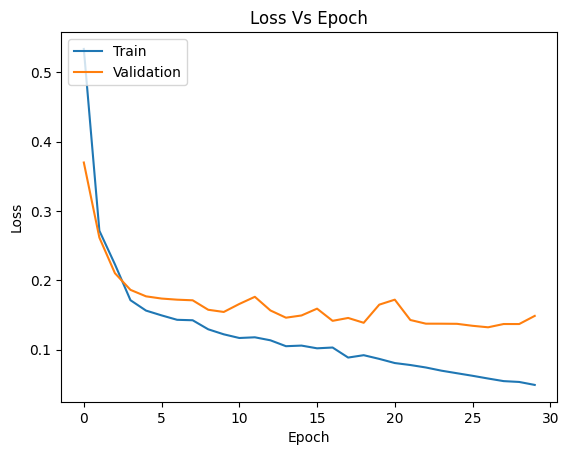

In [ ]:
# 5. Plot los history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


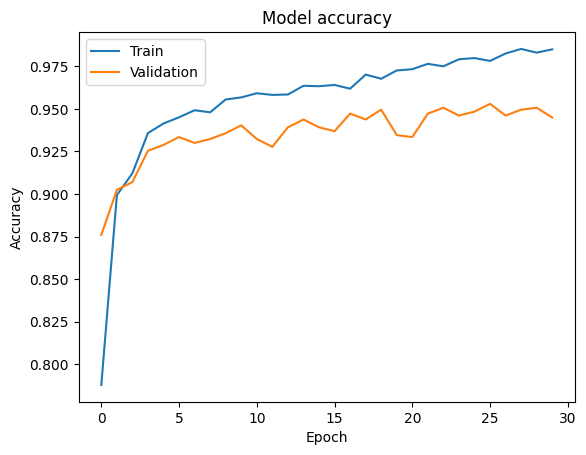

In [ ]:
# 5. Plot training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_report(y_true, y_pred))

Confusion Matrix:
 [[193 211]
 [222 244]]

Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.48      0.47       404
           1       0.54      0.52      0.53       466

    accuracy                           0.50       870
   macro avg       0.50      0.50      0.50       870
weighted avg       0.50      0.50      0.50       870



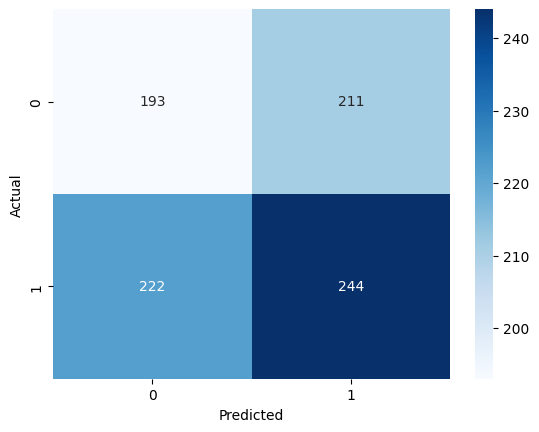

In [ ]:
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
